Versão do Projeto com alteração na arquitetura do modelo.

In [1]:
# Celula 1
!pip install numpy matplotlib librosa tensorflow

In [2]:
# Celula 2
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Reshape, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical

In [3]:
# Celula 3
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Celula 4
# Função para extrair MFCCs usando librosa
def extract_mfccs(file_path):
    wave, sr = librosa.load(file_path, duration=2, sr=22050)
    wave = np.append(wave[0], wave[1:] - 0.98 * wave[:-1])  # Aplicar pré-ênfase
    mfccs = librosa.feature.mfcc(y=wave, sr=sr, n_mfcc=13, hop_length=int(0.02 * sr),
                                 n_fft=256, fmin=32, fmax=8000, n_mels=32)
    return mfccs


In [5]:
# Celula 5
# Defina o caminho do conjunto de dados no Google Drive
dataset_path = "/content/drive/MyDrive/datasetProjetoFinal_IoT&ML"

# Lista para armazenar os dados e rótulos
data = []
labels = []

# Percorrer as classes (chorando, nao_chorando)
for label in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, label)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        try:
            # Carregar os MFCCs usando a função extract_mfccs
            mfccs = extract_mfccs(file_path)

            data.append(mfccs)
            labels.append(label)
        except Exception as e:
            print(f"Erro ao processar {file_path}: {str(e)}")

# Converter para arrays numpy
data = np.array(data)
labels = np.array(labels)

# Dividir o conjunto de dados em treino e validação de forma estratificada
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42, stratify=labels)


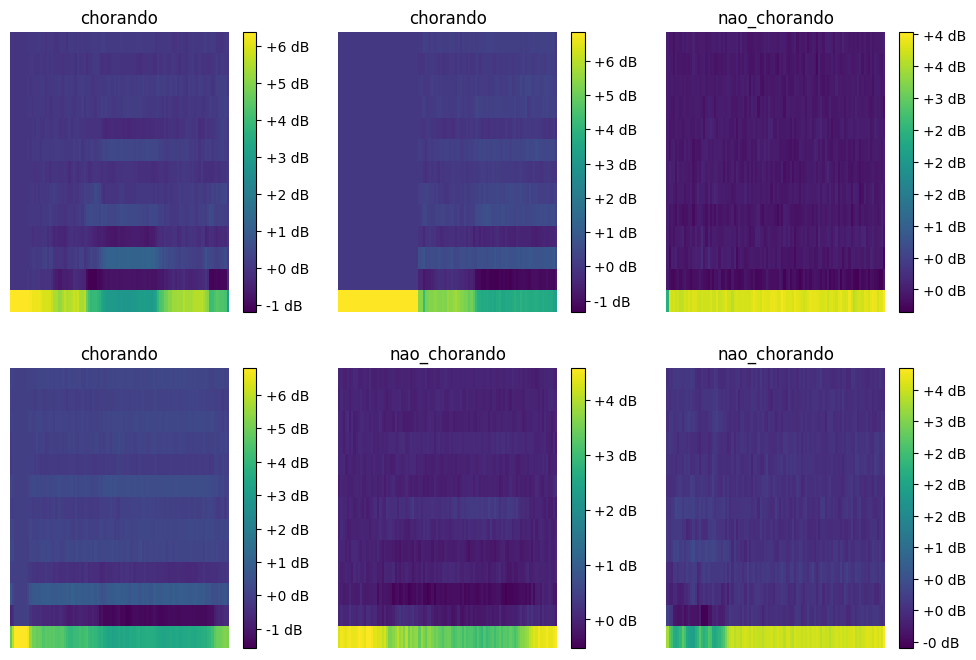

In [6]:
# Celula 6
# Adicionando uma dimensão para representar os canais de cor (1 para imagens em tons de cinza)
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)

# Normalizando os dados para o intervalo [0, 1]
X_train_normalized = X_train / -80.0  # Normalização específica para os MFCCs usados
X_val_normalized = X_val / -80.0

# Plotar MFCCs normalizados para algumas amostras de cada classe
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    librosa.display.specshow(X_train_normalized[i, :, :, 0], cmap='viridis')
    plt.title(y_train[i])
    plt.colorbar(format='%+2.0f dB')
    plt.axis('off')
plt.show()


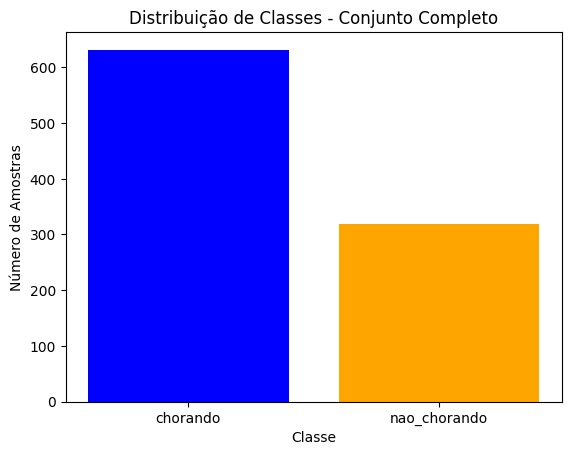

In [7]:
# Celula 7
# Função para plotar a distribuição de classes
def plot_class_distribution(y, title):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts, color=['blue', 'orange'])
    plt.title(title)
    plt.xlabel('Classe')
    plt.ylabel('Número de Amostras')
    plt.show()

# Plotar a distribuição de classes no conjunto de dados completo
plot_class_distribution(labels, 'Distribuição de Classes - Conjunto Completo')

In [58]:
# Celula 8
# Continuando com a definição e treinamento do modelo

# Convertendo rótulos para formato one-hot
y_train_encoded = to_categorical(y_train == 'chorando', num_classes=2)
y_val_encoded = to_categorical(y_val == 'chorando', num_classes=2)

In [59]:
# Celula 9
# Construindo o modelo CNN com Conv1D e camadas adicionais
model = Sequential([
    InputLayer(input_shape=(X_train.shape[1], X_train.shape[2])),
    Conv1D(8, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Dropout(0.25),
    Conv1D(16, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2, strides=2, padding='same'),
    Dropout(0.25),
    Flatten(),
    Dense(2, name='y_pred', activation='softmax')
])

In [60]:
# Celula 10
from tensorflow.keras.optimizers import Adam

# Compilando o modelo com learning rate personalizado
opt = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
# Celula 11
# Treinando o modelo
history = model.fit(X_train_normalized, y_train_encoded,
                    validation_data=(X_val_normalized, y_val_encoded),
                    epochs=100, batch_size=32)

Epoch 1/100
24/24 [==============================] - 1s 13ms/step - loss: 0.4691 - accuracy: 0.7566 - val_loss: 0.3015 - val_accuracy: 0.9058
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.2868 - accuracy: 0.8974 - val_loss: 0.2573 - val_accuracy: 0.8796
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 0.2420 - accuracy: 0.9079 - val_loss: 0.2028 - val_accuracy: 0.9319
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.2004 - accuracy: 0.9342 - val_loss: 0.2045 - val_accuracy: 0.9319
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.1817 - accuracy: 0.9303 - val_loss: 0.1878 - val_accuracy: 0.9372
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.1990 - accuracy: 0.9263 - val_loss: 0.1921 - val_accuracy: 0.9476
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.1668 - accuracy: 0.9342 - val_loss: 0.1868 - val_accuracy: 0.9424
Epoch 8/100


In [62]:
# Celula 12
# Acesso ao histórico de treinamento
train_accuracy = history.history['accuracy'][-1]
print(f"Acurácia no Conjunto de Treinamento: {train_accuracy * 100:.5f}%")

# Avaliando o modelo no conjunto de teste
test_loss, test_accuracy = model.evaluate(X_val_normalized, y_val_encoded)
print(f"Acurácia no Conjunto de Teste: {test_accuracy * 100:.5f}%")


Acurácia no Conjunto de Treinamento: 99.73684%
6/6 [==============================] - 0s 6ms/step - loss: 0.3075 - accuracy: 0.9581
Acurácia no Conjunto de Teste: 95.81152%


In [63]:
# Celula 13
# Exibindo métricas de desempenho
y_pred = np.argmax(model.predict(X_val_normalized), axis=1)
y_true = np.argmax(y_val_encoded, axis=1)

print("Matriz de Confusão:")
print(confusion_matrix(y_true, y_pred))

print("\nRelatório de Classificação:")
print(classification_report(y_true, y_pred))

6/6 [==============================] - 0s 3ms/step
Matriz de Confusão:
[[ 60   4]
 [  4 123]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94        64
           1       0.97      0.97      0.97       127

    accuracy                           0.96       191
   macro avg       0.95      0.95      0.95       191
weighted avg       0.96      0.96      0.96       191



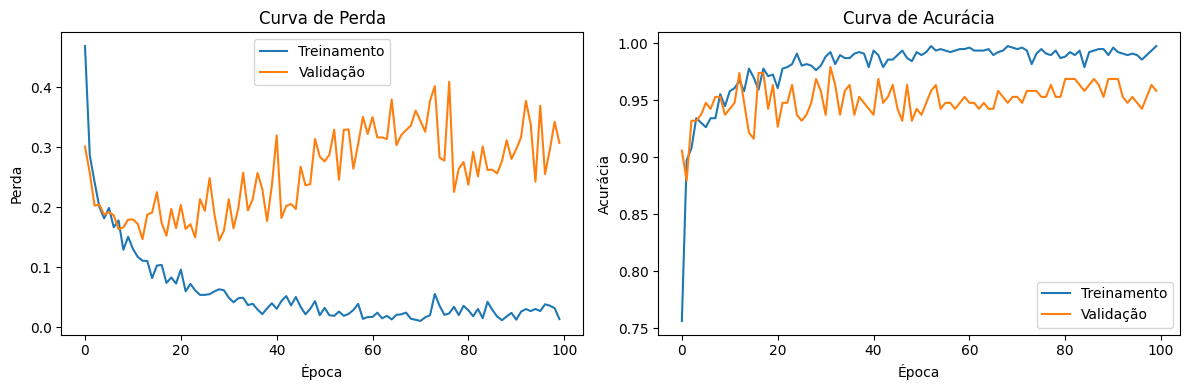

In [64]:
# Celula 15
# Plotando os gráficos de aprendizagem

# Obtendo as métricas de treinamento
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

# Obtendo as métricas de validação
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# Plotando as curvas de perda
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Treinamento')
plt.plot(val_loss, label='Validação')
plt.title('Curva de Perda')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Plotando as curvas de acurácia
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Treinamento')
plt.plot(val_accuracy, label='Validação')
plt.title('Curva de Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()


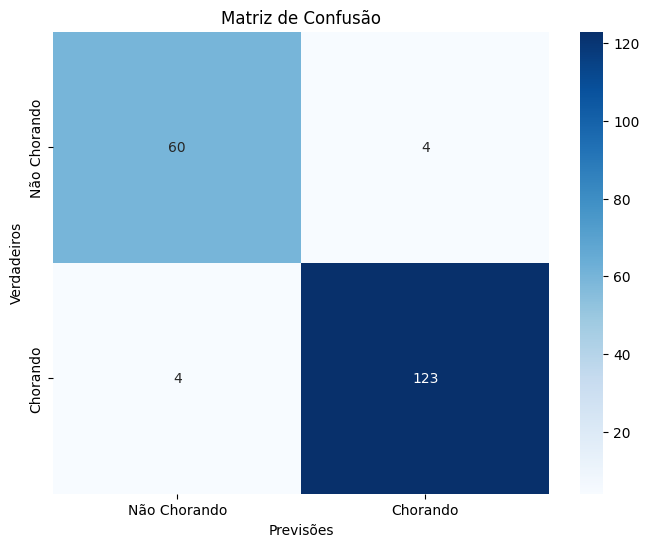

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Celula 16
# Plotando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Chorando', 'Chorando'], yticklabels=['Não Chorando', 'Chorando'])
plt.title('Matriz de Confusão')
plt.xlabel('Previsões')
plt.ylabel('Verdadeiros')
plt.show()
